In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [10]:
# Some basic setup:
# Setup detectron2 logger
import pdb
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/M5-T7-Project/week3

/content/drive/.shortcut-targets-by-id/1STBhu2lV3xFkgz4xYiqnI8vWSfrLMWcR/M5-T7-Project/week3


In [5]:
#%pip install jupytext
#!jupytext --to notebook new.py

Inference using Mask-RCNN model

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


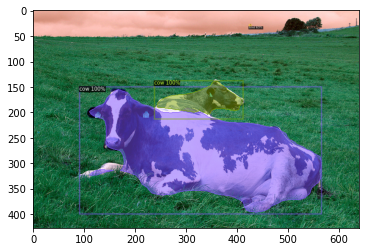

In [6]:
MODEL_NAME = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
RESULT_DIR = 'results_mask'
DATA_PATH = '../COCO'

if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

setup_logger()
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(MODEL_NAME))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_NAME)
predictor = DefaultPredictor(cfg)

for image in os.listdir(DATA_PATH)[0:1]:
    #pdb.set_trace()
    img_path = os.path.join(DATA_PATH, image)
    #print(img_path)
    output_path = os.path.join(RESULT_DIR, image)
    
    # Read image
    im = cv2.imread(img_path)
    
    # Forward pass
    outputs = predictor(im)

    # Save to disk
    v = Visualizer(
        im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    
    #Visualization
    img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(img.get_image()[:, :, ::-1])

    #bboxes= outputs['instances'].get('pred_boxes')
    #mask= outputs['instances'].get('pred_masks')
    #mask= mask.to('cpu')
    #print(mask)
    

Obtaining binary mask

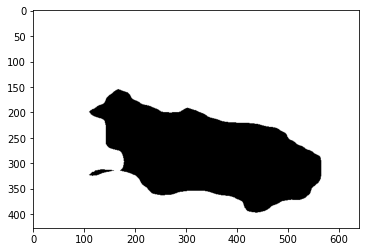

In [7]:
mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
num_instances = 1 #mask_array.shape[0]

mask_array = np.moveaxis(mask_array, 0, -1)

mask_array_instance = []
#img = np.zeros_like(im) #black
h = im.shape[0]
w = im.shape[1]
img_mask = np.zeros([h, w, 3], np.uint8)
color = (200, 100, 255)
for i in range(num_instances):
    img = np.ones_like(im)
    img[:]=255
    mask_array_instance.append(mask_array[:, :, i:(i+1)])
    img = np.where(mask_array_instance[i] == True, 0, img)
    cv2.imwrite("cow_mask.png",img.astype(np.uint8))  #save binary mask
    imshow(img)

Reading and diaplaying images with OpenCV

In [15]:
# Original image, which is the background 
background = cv2.imread('../COCO/bg_sea.jpg')
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Image of the object
img = cv2.imread('../COCO/cow.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Image the object's mask
mask = cv2.imread('cow_mask.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

print("Background shape:", background.shape)
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

Background shape: (229, 640, 3)
Image shape: (427, 640, 3)
Mask shape: (427, 640, 3)


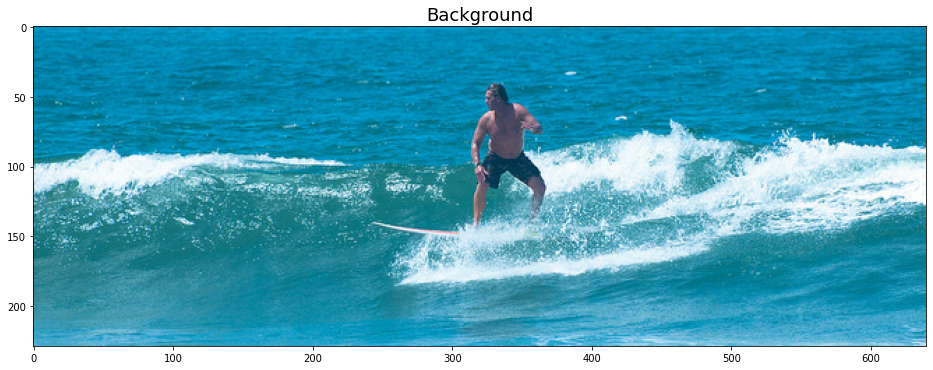

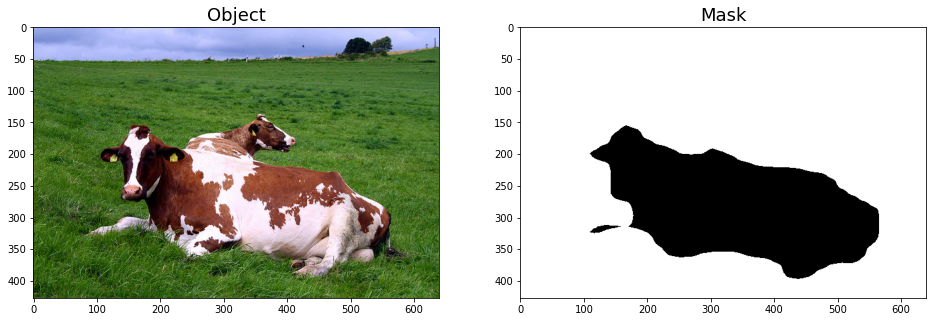

In [16]:
plt.figure(figsize=(16,16))
plt.title("Background", fontsize=18)
plt.imshow(background);

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Mask', fontsize=18);

Removing background from the image of the object

Shape of the image of the object: (427, 640, 3)
Shape of the boolean mask: (427, 640)




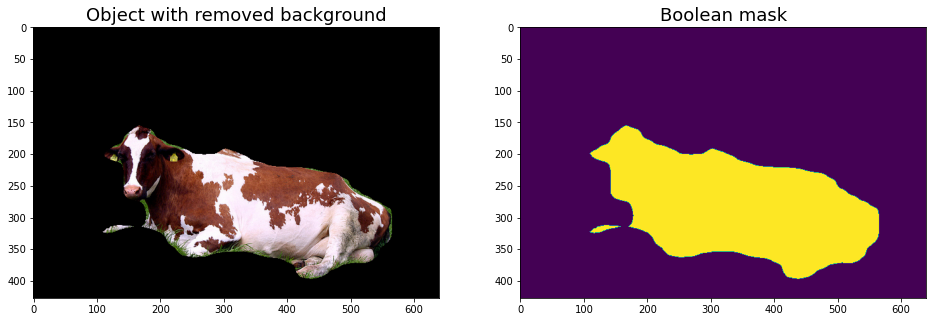

In [17]:
import matplotlib.pyplot as plt
def remove_obj_background(img_path, mask_path):
    '''
    Function returns:
    - image of the object with removed background in CV2 RGB format (numpy array with dimensions (width, height, 3))
    - boolean mask of the object (numpy array with dimensions (width, height))
    '''
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) 
    
    h, w = mask.shape[0], mask.shape[1]
    
    # Boolean mask is a numpy array with two dimensions: width and height.
    # On the original mask, object area is filled with black color, background area is filled with white color.
    # On the boolean mask, object area is filled with True, background area is filled with False.
    mask_boolean = mask[:,:,0] == 0
    img_with_removed_background = img * np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)
    
    return img_with_removed_background, mask_boolean

img_with_removed_background, mask_boolean = remove_obj_background('../COCO/cow.png', 'cow_mask.png')
print("Shape of the image of the object:", img_with_removed_background.shape)
print("Shape of the boolean mask:", mask_boolean.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_with_removed_background)
ax[0].set_title('Object with removed background', fontsize=18)
ax[1].imshow(mask_boolean)
ax[1].set_title('Boolean mask', fontsize=18);

Adding object to background image

In [18]:
def add_obj(background, img, mask, x, y):
    '''
    Arguments:
    background - background image in CV2 RGB format
    img - image of object in CV2 RGB format
    mask - mask of object in CV2 RGB format
    x, y - coordinates of the center of the object image
    0 < x < width of background
    0 < y < height of background
    
    Function returns background with added object in CV2 RGB format
    
    CV2 RGB format is a numpy array with dimensions width x height x 3
    '''
    
    bg = background.copy()
    
    h_bg, w_bg = bg.shape[0], bg.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    # Calculating coordinates of the top left corner of the object image
    x = x - int(w/2)
    y = y - int(h/2)    
    
    mask_boolean = mask[:,:,0] == 0
    mask_rgb_boolean = np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_bg) # h_part - part of the image which overlaps background along y-axis
        w_part = w - max(0, x+w-w_bg) # w_part - part of the image which overlaps background along x-axis

        bg[y:y+h_part, x:x+w_part, :] = bg[y:y+h_part, x:x+w_part, :] * ~mask_rgb_boolean[0:h_part, 0:w_part, :] + (img * mask_rgb_boolean)[0:h_part, 0:w_part, :]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        bg[0:0+h_part, 0:0+w_part, :] = bg[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_boolean)[h-h_part:h, w-w_part:w, :]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_bg)
        w_part = w + x
        
        bg[y:y+h_part, 0:0+w_part, :] = bg[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[0:h_part, w-w_part:w, :] + (img * mask_rgb_boolean)[0:h_part, w-w_part:w, :]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_bg)
        
        bg[0:0+h_part, x:x+w_part, :] = bg[0:0+h_part, x:x+w_part, :] * ~mask_rgb_boolean[h-h_part:h, 0:w_part, :] + (img * mask_rgb_boolean)[h-h_part:h, 0:w_part, :]
    
    return bg

True

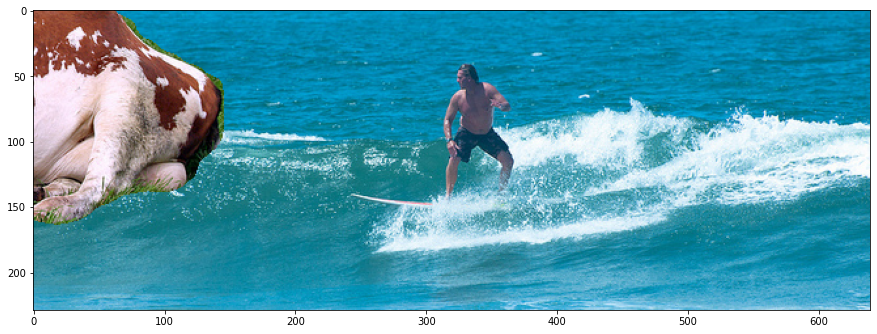

In [52]:
composition = add_obj(background, img, mask, -100, -20)
plt.figure(figsize=(15,15))
plt.imshow(composition)
cv2.imwrite("cow_sea.png", cv2.cvtColor(composition, cv2.COLOR_BGR2RGB))  #save new image

Boxes(tensor([[ 91.1524, 150.0859, 566.3489, 398.5587]]))


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


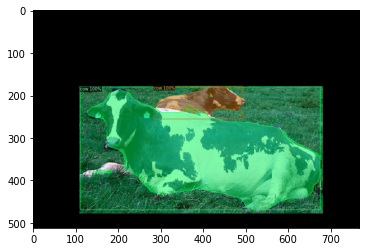

In [44]:
#Show bounding box
bboxes=outputs["instances"].get('pred_boxes').to("cpu")[0]
print(bboxes)
imAux = cv2.rectangle(np.zeros_like(im), pt1=(bboxes.tensor.numpy()[0][0],bboxes.tensor.numpy()[0][1]), pt2=(bboxes.tensor.numpy()[0][2],bboxes.tensor.numpy()[0][3]), color=(1,1,1), thickness = -1)
imAux2 = np.zeros_like(im)
imAux2[imAux==1] = im[imAux==1]
# Predict with noise
imAux2= imAux2.astype(np.uint8)
outBbox = predictor(imAux2)
v = Visualizer(imAux2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outBbox["instances"].to("cpu"))
imshow(out.get_image()[:, :, ::-1])
#cv2.imwrite("boxBlack.jpg",imAux2.astype(np.uint8))